# **MEF Metric Calculator - Individual**
## **High Resolution Sea Ice Diagsnostics Toolset**
 Cameron Carver - University of Cape Town - Jan 2025

This script produces a netcdf file that includes the MEF metric data for a single defined model.<br>
Model data is accessed through Pangeo then preprocesssed through xmip and reprojected using xesmf.<br>
The MEF metric is then calculated accordingly and saved to a netcdf file.

### 1. Import all relevant packages

In [1]:
import os;  
# os.chdir('') # User can provide root directory information here to simplify directory path definitions elsewhere 
import warnings
import copy
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
from clisops.core.subset import subset_bbox  # For subsetting
import numpy as np
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
import intake
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics

### 2. Import Reference Dataset
Import the ancillary file of the observational data. <br>
Data Access https://nsidc.org/data/g02202/versions/4 <br>
Ancilliary File: https://noaadata.apps.nsidc.org/NOAA/G02202_V4/ancillary/<br>
Provides the reference grid of which model data will be reprojected onto.

Define landmask from ancillary file

In [2]:
access_ref_data = 'OBSERVATIONS/SICONC/G02202-cdr-ancillary-sh.nc' # Define location of locally stored grid reference file
ref_ds = xr.open_dataset(access_ref_data)

mask = xr.where(ref_ds.landmask > 0, float('nan'), 1)

### 3. Import Observational Data
Import the monthly observational data. <br>
Data Access https://nsidc.org/data/g02202/versions/4 <br>
Monthly Data https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/monthly/ <br>
Monthyl data was combined into a single NetCDF file along the time dimension.
#### Comparing model data to this data will be used to generate the MEF metric.
The data is sliced to a 36 year period of 1979-2009. <br>
All flagged values are masked out.<br>
Observational values of less than 15 are removed.<br>
Any instances where ice is observed for <= 20 occurances throughout the 432 months are masked out. <br>

The temporal mean is defined for all points on the grid.

In [3]:
access_obs_data='OBSERVATIONS/SICONC/seaice_conc_monthly_sh_n07_v04r00_all.nc' # Define location of locally stored observational reference dataset
obs_ds = xr.open_dataset(access_obs_data)                   # Open dataset
obs_ds = obs_ds.sel(tdim=slice('1978-12','2014-11'))  # Time slice of data
obs_da = obs_ds.cdr_seaice_conc_monthly                     # Select desired variable

obs_da = obs_da.where(obs_da <= 2.51, other=float('nan'))   # Set all flagged values to nan
count = obs_da.where(obs_da>0).count('tdim') # Count number of measurements present at each given point over entire time series
mincount = xr.where(count <= 20, float('nan'), 1) #Identify at which points less than 20 observational datapoints exist
obs_da = obs_da * mincount # If less than 20 obs then mask out
o_mean = obs_da.mean(dim='tdim')       # Temporal mean of observational product

### *Variations*
Uncomment the line of the respective variation mask of interest. <br>This isolates the observational datasets to produce MEF values for the gridpoints with the specified range of observed values.<br> 
**L15**:  Exclude [0,15] <br>
**ZERO**: Isolate 0 <br>
**I015**: Isolate (0,15]<br>
**I1580**: Isolate (15,80]<br>
**I80100**: Isolate (80,100]<br>

In [4]:
# obs_da = obs_da.where(obs_da > 0.15, other=float('nan'))                    # Exclude (-inf,15]          L15
# obs_da = obs_da.where(obs_da == 0, other=float('nan'))                      # Only values = 0%           ZERO
# obs_da = obs_da.where((obs_da > 0) & (obs_da <= 0.15), other=float('nan'))  # Only values = 0-15%        I015
# obs_da = obs_da.where((obs_da > 0.15) & (obs_da <= 0.8), other=float('nan'))# Only values = 15-80%       I1580
# obs_da = obs_da.where((obs_da > 0.80) & (obs_da <= 1), other=float('nan'))  # only values = 80-100%      I80100

### 4a. Define all CMIP models of interest
Comment/uncomment desired list of models to call

In [5]:
# # Historical CMIP Models
# mods = [
# 'GFDL-CM4',        #GOOD
#  # 'IPSL-CM6A-LR',      #CRASH X
#  'MIROC6',         #GOOD
#  'SAM0-UNICON',    #GOOD
#  'CanESM5',        #GOOD
#  'MPI-ESM-1-2-HAM',#GOOD
#  'NESM3',          #GOOD
#  'CAMS-CSM1-0',    #GOOD
#  # 'MPI-ESM1-2-HR',     #CRASH 
#  'MPI-ESM1-2-LR',  #GOOD
#  'GFDL-ESM4',      #GOOD
#  'NorESM2-LM',     #GOOD
#  'MRI-ESM2-0',     #GOOD* double lat/lon warning
#  'FGOALS-f3-L',    #GOOD* lat/lon warning w/xmip
#  'NorESM2-MM',     #GOOD
#  'FIO-ESM-2-0',    #GOOD
#  'BCC-CSM2-MR',    #GOOD
#  'BCC-ESM1',       #GOOD
#  'CMCC-CM2-SR5',   #GOOD
#  # 'EC-Earth3-AerChem',  #CRASH
#  'TaiESM1',        #GOOD
#  'NorCPM1',        #GOOD
#  # 'IPSL-CM5A2-INCA',   #CRASH X
#  'ACCESS-ESM1-5',  #GOOD
#  'ACCESS-CM2',     #GOOD
#  # 'CMCC-CM2-HR4',      #CRASH X
#  # 'EC-Earth3',         #CRASH X
#  # 'EC-Earth3-Veg-LR',  #CRASH
#  # 'EC-Earth3-Veg',     #NOT IN CAT1
#  'CAS-ESM2-0',      #GOOD
#  'FGOALS-g3',       #GOOD
#  # 'EC-Earth3-CC',      #CRASH
#  'CMCC-ESM2',       #GOOD
#  # 'IPSL-CM6A-LR-INCA'  #CRASH
# ]

### 4b. Define all HighResMIP models of interest

In [6]:
# # # HighResMIP Models CAT1
mods = [
    'CMCC-CM2-HR4',    #GOOD 
    'CMCC-CM2-VHR4',   #GOOD
    'HadGEM3-GC31-HM', #GOOD
    'HadGEM3-GC31-LL', #GOOD
    'HadGEM3-GC31-MM', #GOOD
    # 'CESM1-CAM5-SE-HR', #failed to load
    # 'CESM1-CAM5-SE-LR', #failed to load
    # 'HadGEM3-GC31-HH', #CRASH
    'GFDL-CM4C192', ]  #GOOD

### 5. Define Pangeo Catalog to call
Comment/uncomment lines to swap catalogs

In [7]:
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog.json" # Only stores that pass current tests
# url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog_noqc.json" # Only stores that fail current tests
# url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog_retracted.json" # Only stores that have been retracted by ESGF
cmip6 = intake.open_esm_datastore(url)   ## HighResMIP catalogs, must uncomment one of above

# cmip6 = google_cmip_col()    ##CMIP6 catalog

### 6. Call list of models from catalog
Adjust according to desired search criteria and CMIP6 vs HighResMIP

In [8]:
# get the list of CMIP6 historical simulations with variable siconc
cat = cmip6.search(
    source_id=mods[0],   # !!Individual Model Selection!!
    variable_id='siconc',
    table_id='SImon',
    # experiment_id='historical',   # Uncomment for historical CMIP Models
    activity_id='HighResMIP',    # Uncomment for HighResMIP Models
    member_id='r1i1p1f1',
    grid_label='gn'
)
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,sub_experiment_id,variant_label,version,zstore
0,HighResMIP,CMCC,CMCC-CM2-HR4,hist-1950,r1i1p1f1,SImon,siconc,gn,none,r1i1p1f1,v20200917,gs://cmip6/cmip6-pgf-ingestion-test/zarr_store...


 ### 7. Preprocess all called models
 Preprocesesed with xMIP - https://cmip6-preprocessing.readthedocs.io/en/latest/?badge=latest

In [9]:
ddict = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


### 8. List all models that have been preprocessed

In [10]:
# list of preprocessed models
mlist = list(ddict.keys())
print(mlist)

['HighResMIP.CMCC.CMCC-CM2-HR4.hist-1950.SImon.gn']


### 9. Import Model Data
Slice to defined 40 year period 1978-2014

In [11]:
# %% Import Model Data (SOURCE)
model_ds = ddict[mlist[0]]
model_ds = model_ds.sel(time=slice('1978-12','2014-11'))  # Time slice of data

model_ds['siconc'] = model_ds['siconc'].where(model_ds['siconc'] <= 100, other=float('nan'))   # Set all flagged values to nan

dims_to_keep = ['time', 'y', 'x','vertex','bnds']  # Dimensions to be kept
model_ds = model_ds.squeeze(dim=[dim for dim in model_ds.dims if dim not in dims_to_keep])
model_ds

<xarray.Dataset> Size: 3GB
Dimensions:            (time: 432, y: 1050, x: 1440, vertex: 4, bnds: 2)
Coordinates:
    lat                (y, x) float32 6MB dask.array<chunksize=(525, 720), meta=np.ndarray>
    lon                (y, x) float32 6MB dask.array<chunksize=(525, 720), meta=np.ndarray>
  * time               (time) object 3kB 1978-12-16 12:00:00 ... 2014-11-16 0...
    longitude_bnds     (y, x, vertex) float32 24MB dask.array<chunksize=(525, 720, 4), meta=np.ndarray>
    latitude_bnds      (y, x, vertex) float32 24MB dask.array<chunksize=(525, 720, 4), meta=np.ndarray>
    time_bounds        (time, bnds) object 7kB dask.array<chunksize=(17, 2), meta=np.ndarray>
  * y                  (y) int64 8kB 0 1 2 3 4 5 ... 1045 1046 1047 1048 1049
  * x                  (x) int64 12kB 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
    variant_label      <U8 32B 'r1i1p1f1'
    sub_experiment_id  <U4 16B 'none'
Dimensions without coordinates: vertex, bnds
Data variables:
    siconc             (time, y, x) float32 3GB dask.array<chunksize=(17, 525, 720), meta=np.ndarray>
Attributes: (12/65)
    CDI:                                 Climate Data Interface version 1.9.8...
    CDO:                                 Climate Data Operators version 1.9.8...
    Conventions:                         CF-1.7 CMIP-6.2
    activity_id:                         HighResMIP
    branch_method:                       fixed historical forcing from 1950 w...
    branch_time_in_child:                365.0
    ...                                  ...
    intake_esm_attrs:sub_experiment_id:  none
    intake_esm_attrs:variant_label:      r1i1p1f1
    intake_esm_attrs:version:            v20200917
    intake_esm_attrs:zstore:             gs://cmip6/cmip6-pgf-ingestion-test/...
    intake_esm_attrs:_data_format_:      zarr
    intake_esm_dataset_key:              HighResMIP.CMCC.CMCC-CM2-HR4.hist-19...

### 10. Define plot details and model name

In [12]:
cmap = plt.get_cmap("magma")
cmap.set_bad("lightgrey")

name = mlist[0].split('.')
model = name[2]
model

'CMCC-CM2-HR4'

### 11. Plot model native grid and siconc
Visualise the southern hemisphere native grid of the model dataset and the corresonding sea ice concentratoion. 

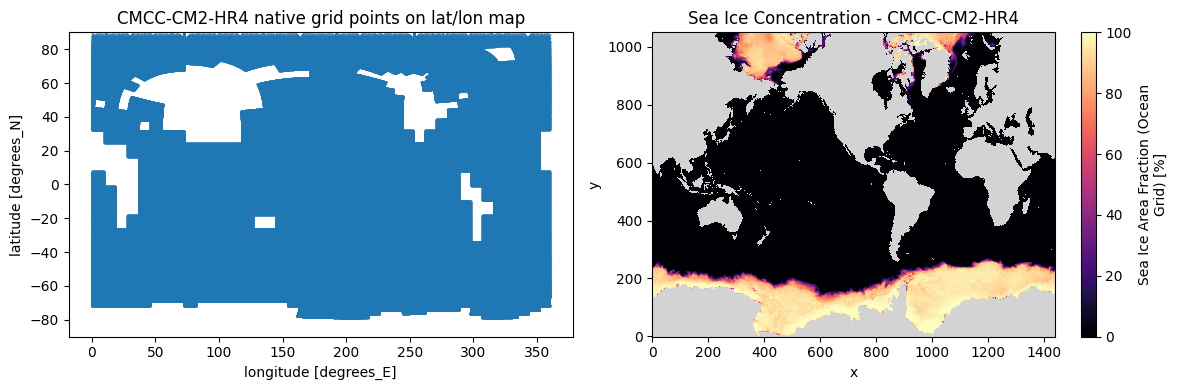

In [13]:
# %% INPUT - MODEL
# Let's look at the grid shape itself and the data for one time step
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].scatter(x=model_ds.lon.values, y=model_ds.lat.values, s=0.1)
axs[0].set_title(f'{model} native grid points on lat/lon map')
axs[0].set_ylim(-90, 90)
axs[0].set_ylabel(f"latitude [{model_ds.lat.units}]")
axs[0].set_xlabel(f"longitude [{model_ds.lon.units}]")
model_ds.siconc.isel(time=8).plot(ax=axs[1], cmap=cmap , vmin=0)
axs[1].set_title(f'Sea Ice Concentration - {model}')
fig.tight_layout()

### 12. Reproject with xESMF
Bilinear reprojection onto reference grid using xESMF (https://pavics-sdi.readthedocs.io/en/latest/notebooks/regridding.html) <br>

In [14]:
# %% TARGET - REFERENCE
bbox = dict(lon_bnds=[-180, 180], lat_bnds=[-80, -50])
ds_tgt = subset_bbox(ref_ds, **bbox)

reg_bil = xe.Regridder(model_ds, ds_tgt, "bilinear", periodic=True,)
warnings.filterwarnings("ignore", category=FutureWarning)

# Apply the regridding weights to the input sea ice concentration data
sic_bil = reg_bil(model_ds.siconc)
model_rp = xr.Dataset({"siconc": sic_bil})

### 13. Overlay land mask 
From observational ancillary file

In [15]:
tct = model_rp.coords['time'].size
for i in range(0,tct,1):
    model_rp.siconc[i,:,:] = model_rp.siconc[i,:,:]*mask

### 14. Align time coordinates
Write time dimension of observational data onto model data.

In [16]:
model_ds = model_rp.assign_coords(time=obs_ds['time'])  # Set time coords of model ds to be the same as the obs ds
model_ds = model_ds.swap_dims({'tdim': 'time'})
model_ds = model_ds.swap_dims({'time': 'tdim'})

# Check for max >1 
model_da = model_ds.siconc / 100    # Select desired variable and scale to match obs scale of 0-1
# model_name, exp_id = model_ds.model_name, model_ds.exp_id   # Call model name from attributes

### 15. Visualise siconc
Ensure both model and observstional data are on the same scale

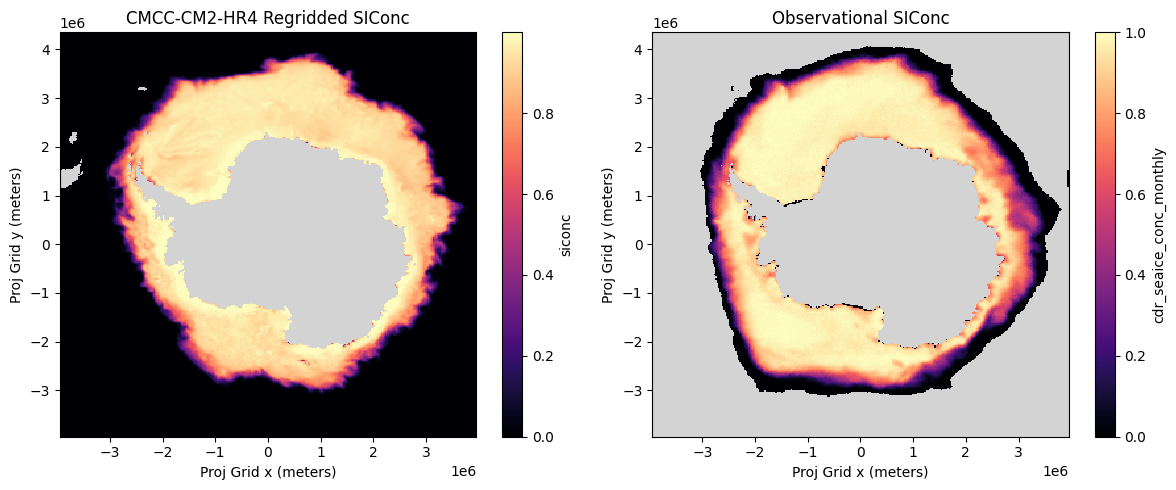

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

model_da.isel(tdim=8).plot(ax=axs[0], cmap=cmap , vmin=0)
obs_da.isel(tdim=8).plot(ax=axs[1], cmap=cmap , vmin=0)

axs[0].set_title(f'{model} Regridded SIConc')
axs[1].set_title('Observational SIConc')
axs[0].set_ylabel('Proj Grid y (meters)'); axs[0].set_xlabel('Proj Grid x (meters)')
axs[1].set_ylabel('Proj Grid y (meters)'); axs[1].set_xlabel('Proj Grid x (meters)')

fig.tight_layout()

### 16. Annual Temporal Mean

In [18]:
MEF_num = (obs_da-model_da) ** 2       # cell-wise RMSD
MEF_num = MEF_num.sum(dim=['tdim'])    # Temporal sum of cell-wise RMSD

MEF_den = (obs_da-o_mean) ** 2         # cell-wise RMSD
MEF_den = MEF_den.sum(dim='tdim')      # Temporal sum of cell-wise SD

MEF_a = (1 - (MEF_num/MEF_den))

### 17. Monthly Temporal Mean

In [19]:
MEF_num = (obs_da-model_da) ** 2        # cell-wise RMSD
MEF_num = MEF_num.groupby('time.month').sum(dim=['tdim'])    # Temporal mean of cell-wise RMSD

MEF_den = (obs_da-o_mean) ** 2          # cell-wise RMSD
MEF_den = MEF_den.groupby('time.month').sum(dim='tdim')      # Temporal mean of cell-wise SD

MEF_m = (1 - (MEF_num/MEF_den))

### 18. Seasonal Temporal Mean

In [20]:
MEF_num = (obs_da-model_da) ** 2        # cell-wise RMSD
MEF_num = MEF_num.groupby('time.season').sum(dim=['tdim'])    # Temporal mean of cell-wise RMSD

MEF_den = (obs_da-o_mean) ** 2          # cell-wise RMSD
MEF_den = MEF_den.groupby('time.season').sum(dim='tdim')      # Temporal mean of cell-wise SD

MEF_s = (1 - (MEF_num/MEF_den))

### 19. Spatial Time Series

In [21]:
MEF_num = (obs_da-model_da) ** 2
MEF_num = MEF_num.sum(dim=['x','y'])

MEF_den = (obs_da-o_mean) ** 2 
MEF_den = MEF_den.sum(dim=['x','y'])

MEF_b = (1 - (MEF_num/MEF_den))

### 20. Save each metric to dataset

In [22]:
dataset = xr.Dataset({'MEF_a': MEF_a, 'MEF_s': MEF_s, 'MEF_m': MEF_m, 'MEF_b': MEF_b, 
                      'model_name': model})
dataset

<xarray.Dataset> Size: 14MB
Dimensions:            (x: 316, y: 332, season: 4, month: 12, tdim: 432)
Coordinates:
    xgrid              (x) float32 1kB -3.938e+06 -3.912e+06 ... 3.938e+06
    ygrid              (y) float32 1kB 4.338e+06 4.312e+06 ... -3.938e+06
  * x                  (x) float32 1kB -3.938e+06 -3.912e+06 ... 3.938e+06
  * y                  (y) float32 1kB 4.338e+06 4.312e+06 ... -3.938e+06
    variant_label      <U8 32B 'r1i1p1f1'
    sub_experiment_id  <U4 16B 'none'
    crs                int32 4B -2147483647
  * season             (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
  * month              (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    time               (tdim) datetime64[ns] 3kB 1978-12-01 ... 2014-11-01
  * tdim               (tdim) datetime64[ns] 3kB 1978-12-01 ... 2014-11-01
Data variables:
    MEF_a              (y, x) float64 839kB dask.array<chunksize=(332, 316), meta=np.ndarray>
    MEF_s              (season, y, x) float64 3MB dask.array<chunksize=(4, 332, 316), meta=np.ndarray>
    MEF_m              (month, y, x) float64 10MB dask.array<chunksize=(12, 332, 316), meta=np.ndarray>
    MEF_b              (tdim) float64 3kB dask.array<chunksize=(17,), meta=np.ndarray>
    model_name         <U12 48B 'CMCC-CM2-HR4'

### 22. Export dataset to netCDF
Specifiy desired file location and name

In [23]:
# dataset.to_netcdf(f'CMIP-MEF/{model}-MEF.nc 
# dataset.to_netcdf(f'HRMIP-MEF/{model}-MEF.nc')